<div style="text-align:center; border: 1px solid #808080; padding: 10px;">
  <h1 style="color: gray; font-weight: bold;">Credit Card Predictive Analysis | EDA:</h1>
  <h2 style="color: gray; font-weight: bold;">Credit Risk Classification Using  Model of Best Fit</h2>
</div>

# **Problem Statement**

- Credit score cards are used in the financial industry to predict the likelihood of credit card defaults and guide the issuance of credit cards. These scores rely on applicants' personal data and historical information, quantifying risk objectively.

**Project Goal**:
- The primary objective of this project is to **build a predictive model** that accurately identifies whether a customer is **high-risk** for credit card approval, enabling data-driven decision-making in the credit screening process.

## Huggingface model samples
- aegishield/credit_card_purchase_prediction
- timhbach/Team-Gryffindor-DistilBERT-finetuned-ner-creditcardcontract
- PabitraJiban/Credit-card-collection-intent-classification

## Load libraries & helpers

In [1]:
import os
import sys
import importlib
from autoviz import AutoViz_Class

sys.path.append("../scripts")
from data_processing_framework import *
from ml_pipeline_utils import *

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


## Data load & understanding

In [2]:
# load dataset 1
appl_df = fetch_kaggle_dataset(search_query="credit-card-approval-prediction")


🔹 Available Datasets:

Dataset 1: rikdifos/credit-card-approval-prediction - Credit Card Approval Prediction
Files:
  - application_record.csv (Size: 54342959 bytes)
  - credit_record.csv (Size: 15367102 bytes)

Dataset 2: caesarmario/application-data - Credit Card Approval Prediction (Cleaned Version)
Files:
  - Application_Data.csv (Size: 7712142 bytes)

Dataset 3: rohitudageri/credit-card-details - Credit card Details Binary Classification Problem
Files:
  - Credit_card.csv (Size: 186815 bytes)
  - Credit_card_label.csv (Size: 17042 bytes)

Dataset 4: laotse/credit-card-approval - Credit Card Approval - With Target
Files:
  - credit_card_approval.csv (Size: 69493242 bytes)

Dataset 5: pranaybshah/credit-card-approval-prediction-dataset - Credit Card Approval Prediction Dataset
Files:
  - Credit_card.csv (Size: 186815 bytes)
  - Credit_card_label.csv (Size: 17042 bytes)



Enter the number of the dataset you want to use:  1



🔹 Available Files:
1. application_record.csv (Size: 54342959 bytes)
2. credit_record.csv (Size: 15367102 bytes)



Enter the number of the file you want to use:  1


✅ Successfully read with utf-8 encoding

✅ Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 

In [3]:
# load dataset 2
credits_df = fetch_kaggle_dataset(search_query="credit-card-approval-prediction")


🔹 Available Datasets:

Dataset 1: rikdifos/credit-card-approval-prediction - Credit Card Approval Prediction
Files:
  - application_record.csv (Size: 54342959 bytes)
  - credit_record.csv (Size: 15367102 bytes)

Dataset 2: caesarmario/application-data - Credit Card Approval Prediction (Cleaned Version)
Files:
  - Application_Data.csv (Size: 7712142 bytes)

Dataset 3: rohitudageri/credit-card-details - Credit card Details Binary Classification Problem
Files:
  - Credit_card.csv (Size: 186815 bytes)
  - Credit_card_label.csv (Size: 17042 bytes)

Dataset 4: laotse/credit-card-approval - Credit Card Approval - With Target
Files:
  - credit_card_approval.csv (Size: 69493242 bytes)

Dataset 5: pranaybshah/credit-card-approval-prediction-dataset - Credit Card Approval Prediction Dataset
Files:
  - Credit_card.csv (Size: 186815 bytes)
  - Credit_card_label.csv (Size: 17042 bytes)



Enter the number of the dataset you want to use:  1



🔹 Available Files:
1. application_record.csv (Size: 54342959 bytes)
2. credit_record.csv (Size: 15367102 bytes)



Enter the number of the file you want to use:  2


✅ Successfully read with utf-8 encoding

✅ Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
None


----
*Credit df:*
> 1048575 entries, Data columns (total 3 columns)

*Application df:*
> 438557 entries , Data columns (total 18 columns)


| Feature Name    | Explanation     | Remarks                                                                                       |
|-----------------|-----------------|-----------------------------------------------------------------------------------------------|
| MONTHS_BALANCE  | Record month    | The month of the extracted data is the starting point, backwards, `0 is the current month`, `-1 is the previous month`, and so on |
| STATUS          | Status          | `0: 1-29 days past due` `1: 30-59 days past due` `2: 60-89 days overdue` `3: 90-119 days overdue` `4: 120-149 days overdue` `5: Overdue or bad debts, write-offs for more than 150 days` `C: paid off that month` `X: No loan for the month` |

---

## Creating the target variable (is_high_risk)

---
To create the target column Is_high_risk (binary: 1 for risky, 0 for not risky),

- Step 1: Define Risky Statuses: Based on the STATUS column, classify customers as "risky" if they have ever had a severe delinquency (e.g., 60+ days overdue). Common thresholds include:
- > STATUS = 2, 3, 4, or 5 (60+ days past due).

- Step 2: Aggregate Customer Behavior: Group the data by ID and check if the customer has any risky status in their history:
- I will merge the two dataframes based on the `ID` column, using the `inner` parameter in the `pd.merge` function.
- ---

In [12]:
# Define risky statuses (adjust threshold as needed)
risky_statuses = {'2', '3', '4', '5'}

In [13]:
# Group by ID and check if they EVER had a risky status
target_df = credits_df.groupby('ID')['STATUS'].apply(
    lambda s: 1 if s.isin(risky_statuses).any() else 0
).reset_index(name='is_high_risk')

In [15]:
# Filter for the most recent application (MONTHS_BALANCE=0)
latest_data = credits_df[credits_df['MONTHS_BALANCE'] == 0].copy()

# Drop duplicate IDs (if any)
latest_data = latest_data.drop_duplicates(subset='ID', keep='first')

In [22]:
# Merge target variable with latest credit data
credits_df = latest_data.merge(target_df, on='ID', how='inner')
credits_df.head()

,ID,MONTHS_BALANCE,STATUS,is_high_risk
0,5001711,0,X,0
1,5001712,0,C,0
2,5001713,0,X,0
3,5001714,0,X,0
4,5001715,0,X,0


In [23]:
# Merge target variable (credits_df)  with latest application data
merged_df = appl_df.merge(credits_df, on='ID', how='inner')
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,is_high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,C,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0,0
4,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,C,0


**Column Description of Merged Dataset:**

| Feature Name        | Explanation                  | Remarks                                                  |
|---------------------|------------------------------|----------------------------------------------------------|
| ID                  | Client number                |                                                          |
| CODE_GENDER         | Gender                       |                                                          |
| FLAG_OWN_CAR        | Is there a car               |                                                          |
| FLAG_OWN_REALTY     | Is there a property          |                                                          |
| CNT_CHILDREN        | Number of children           |                                                          |
| AMT_INCOME_TOTAL    | Annual income                |                                                          |
| NAME_INCOME_TYPE    | Income category              |                                                          |
| NAME_EDUCATION_TYPE | Education level              |                                                          |
| NAME_FAMILY_STATUS  | Marital status               |                                                          |
| NAME_HOUSING_TYPE   | Way of living (House Type)                |                                                          |
| DAYS_BIRTH          | Birthday                     | Count backwards from current day (0), -1 means yesterday |
| DAYS_EMPLOYED       | Start date of employment     | Count backwards from current day(0). If positive, it means the person is currently unemployed. |
| FLAG_MOBIL          | Is there a mobile phone      |                                                          |
| FLAG_WORK_PHONE     | Is there a work phone        |                                                          |
| FLAG_PHONE          | Is there a phone             |                                                          |
| FLAG_EMAIL          | Is there an email            |                                                          |
| OCCUPATION_TYPE     | Occupation                   |                                                          |
| CNT_FAM_MEMBERS     | Family size                  |                                                          |


## Initial EDA / Data Quality Checks

Shape of your Data Set loaded: (24672, 21)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']
    Integer-Categorical Columns: ['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
    String-Categorical Columns: ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'STATUS']
    Factor-Categorical Columns: []
    String-Boolean Columns: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    Numeric-Boolean Columns: ['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: ['ID']
    Columns that

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
CODE_GENDER,object,0.000000,0,,,No issue
FLAG_OWN_CAR,object,0.000000,0,,,No issue
FLAG_OWN_REALTY,object,0.000000,0,,,No issue
CNT_CHILDREN,int64,0.000000,0,0.000000,19.000000,"Column has 205 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them., Column has a high correlation with ['CNT_FAM_MEMBERS']. Consider dropping one of them."
AMT_INCOME_TOTAL,float64,0.000000,NA,27000.000000,1575000.000000,Column has 496 outliers greater than upper bound (387000.00) or lower than lower bound(-45000.00). Cap them or remove them.
NAME_INCOME_TYPE,object,0.000000,0,,,1 rare categories: ['Student']. Group them into a single category or drop the categories.
NAME_EDUCATION_TYPE,object,0.000000,0,,,1 rare categories: ['Academic degree']. Group them into a single category or drop the categories.
NAME_FAMILY_STATUS,object,0.000000,0,,,No issue
NAME_HOUSING_TYPE,object,0.000000,0,,,"2 rare categories: ['Office apartment', 'Co-op apartment']. Group them into a single category or drop the categories."
DAYS_BIRTH,int64,0.000000,49,-25152.000000,-7489.000000,No issue


Total Number of Scatter Plots = 3
All Plots are saved in reports_html\is_high_risk
Time to run AutoViz = 11 seconds 


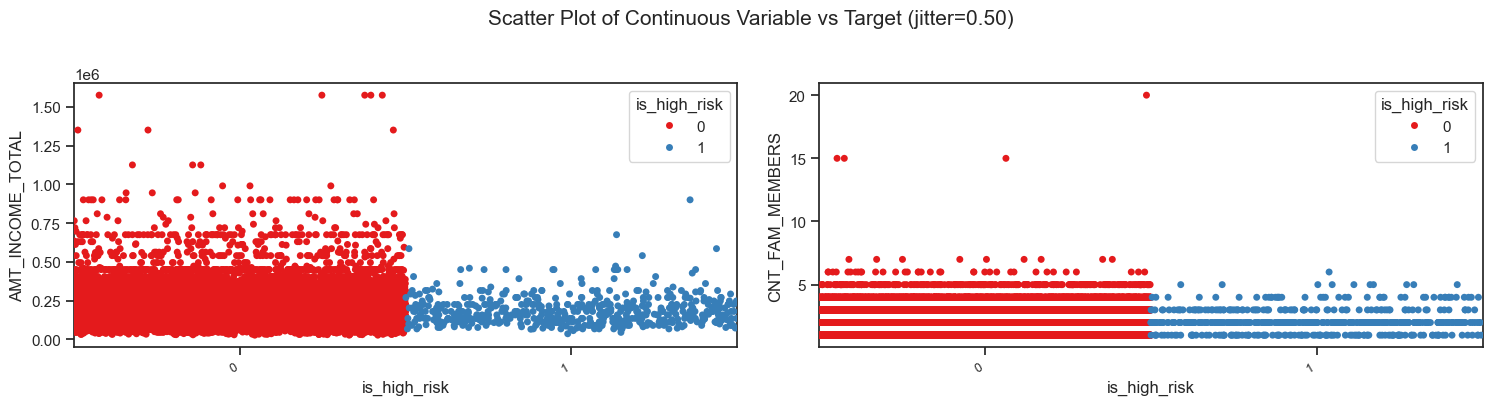

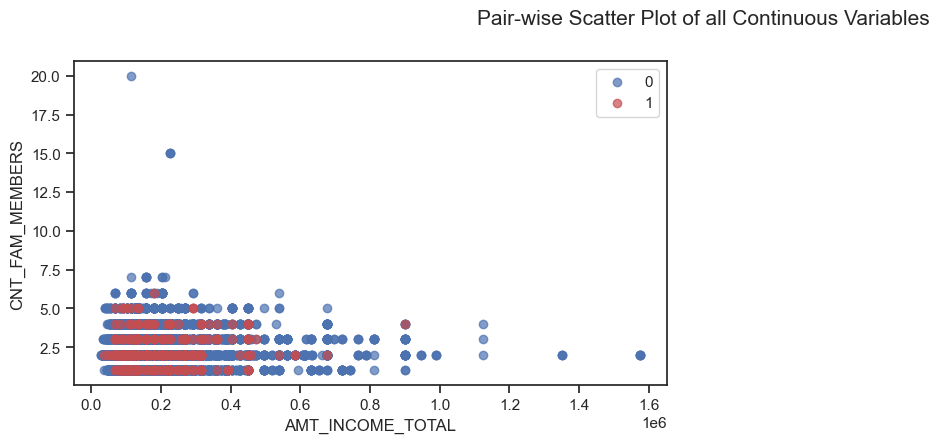

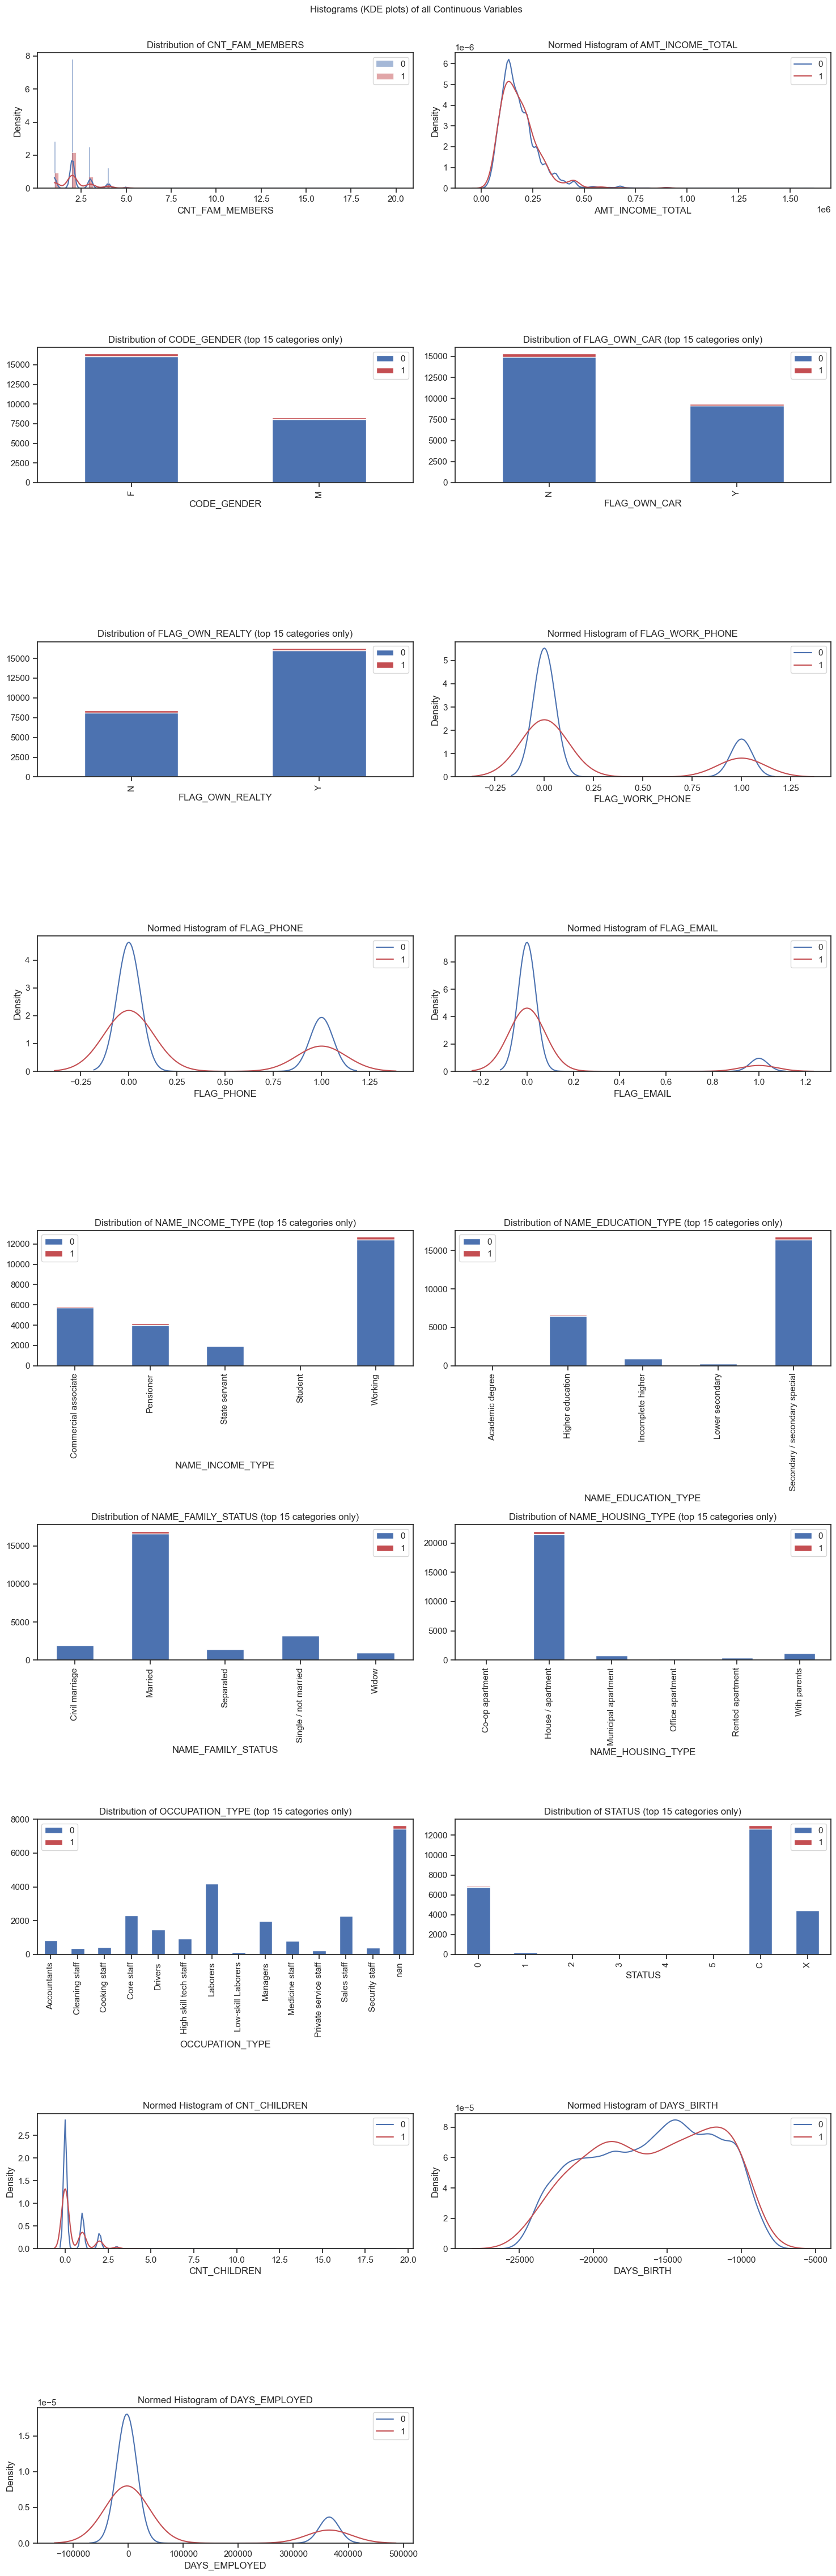

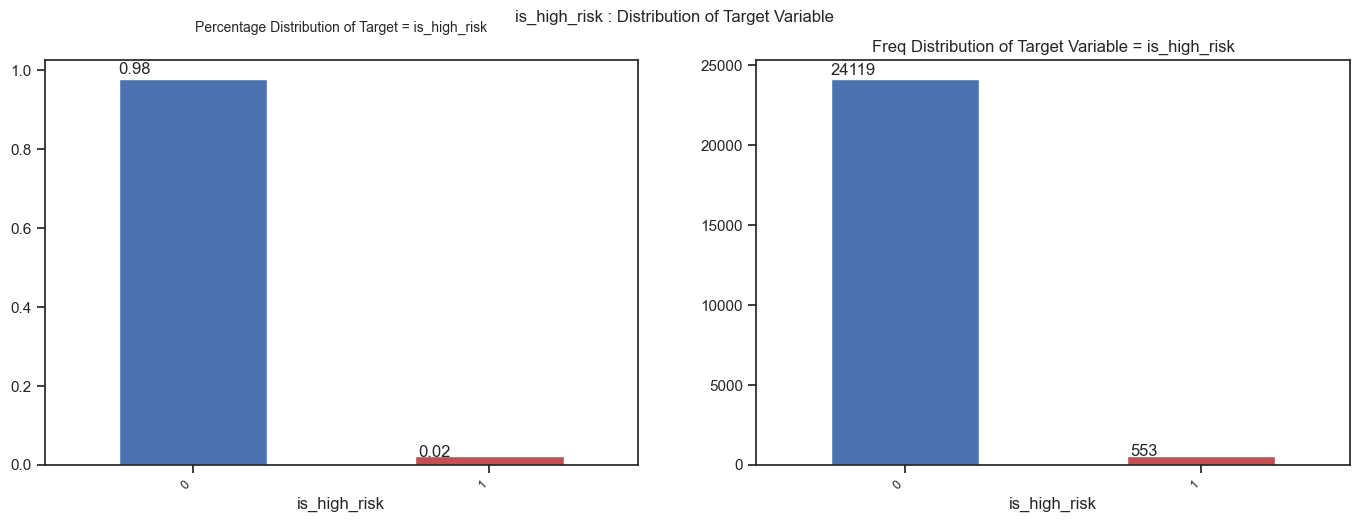

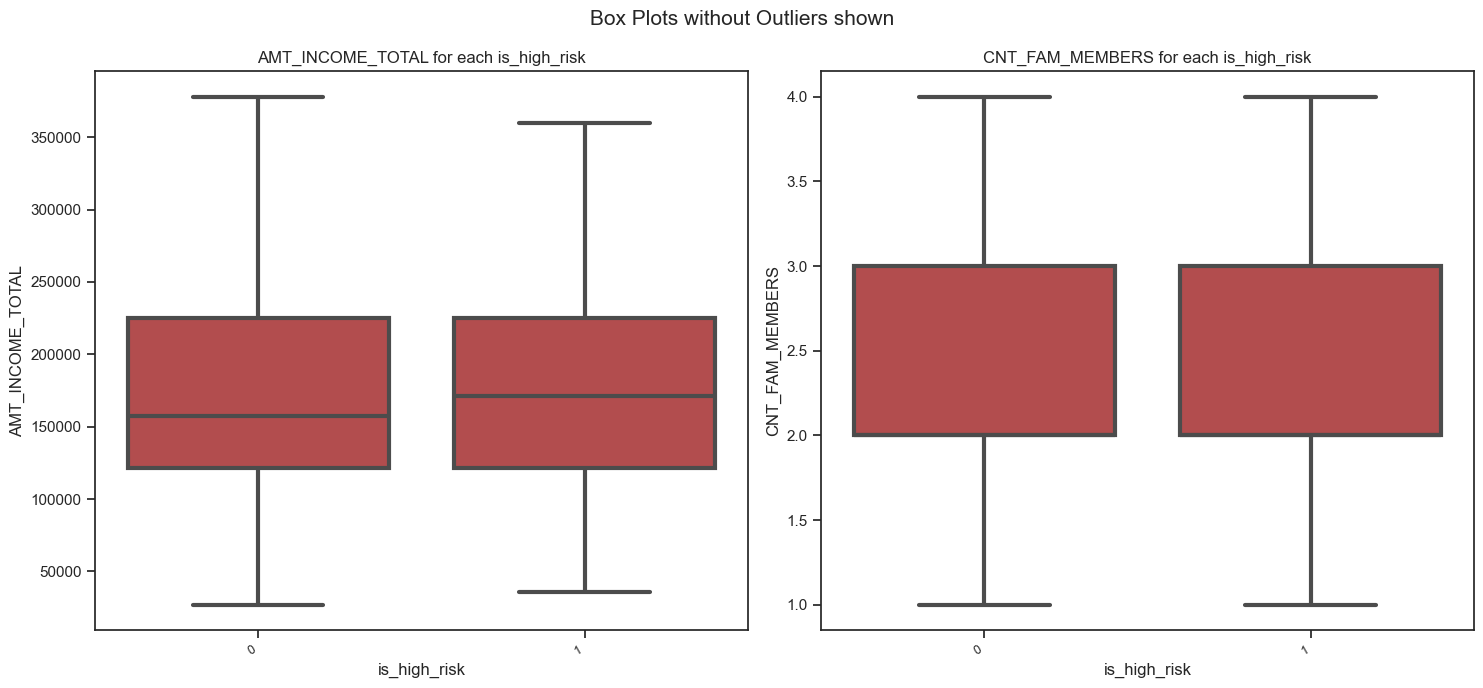

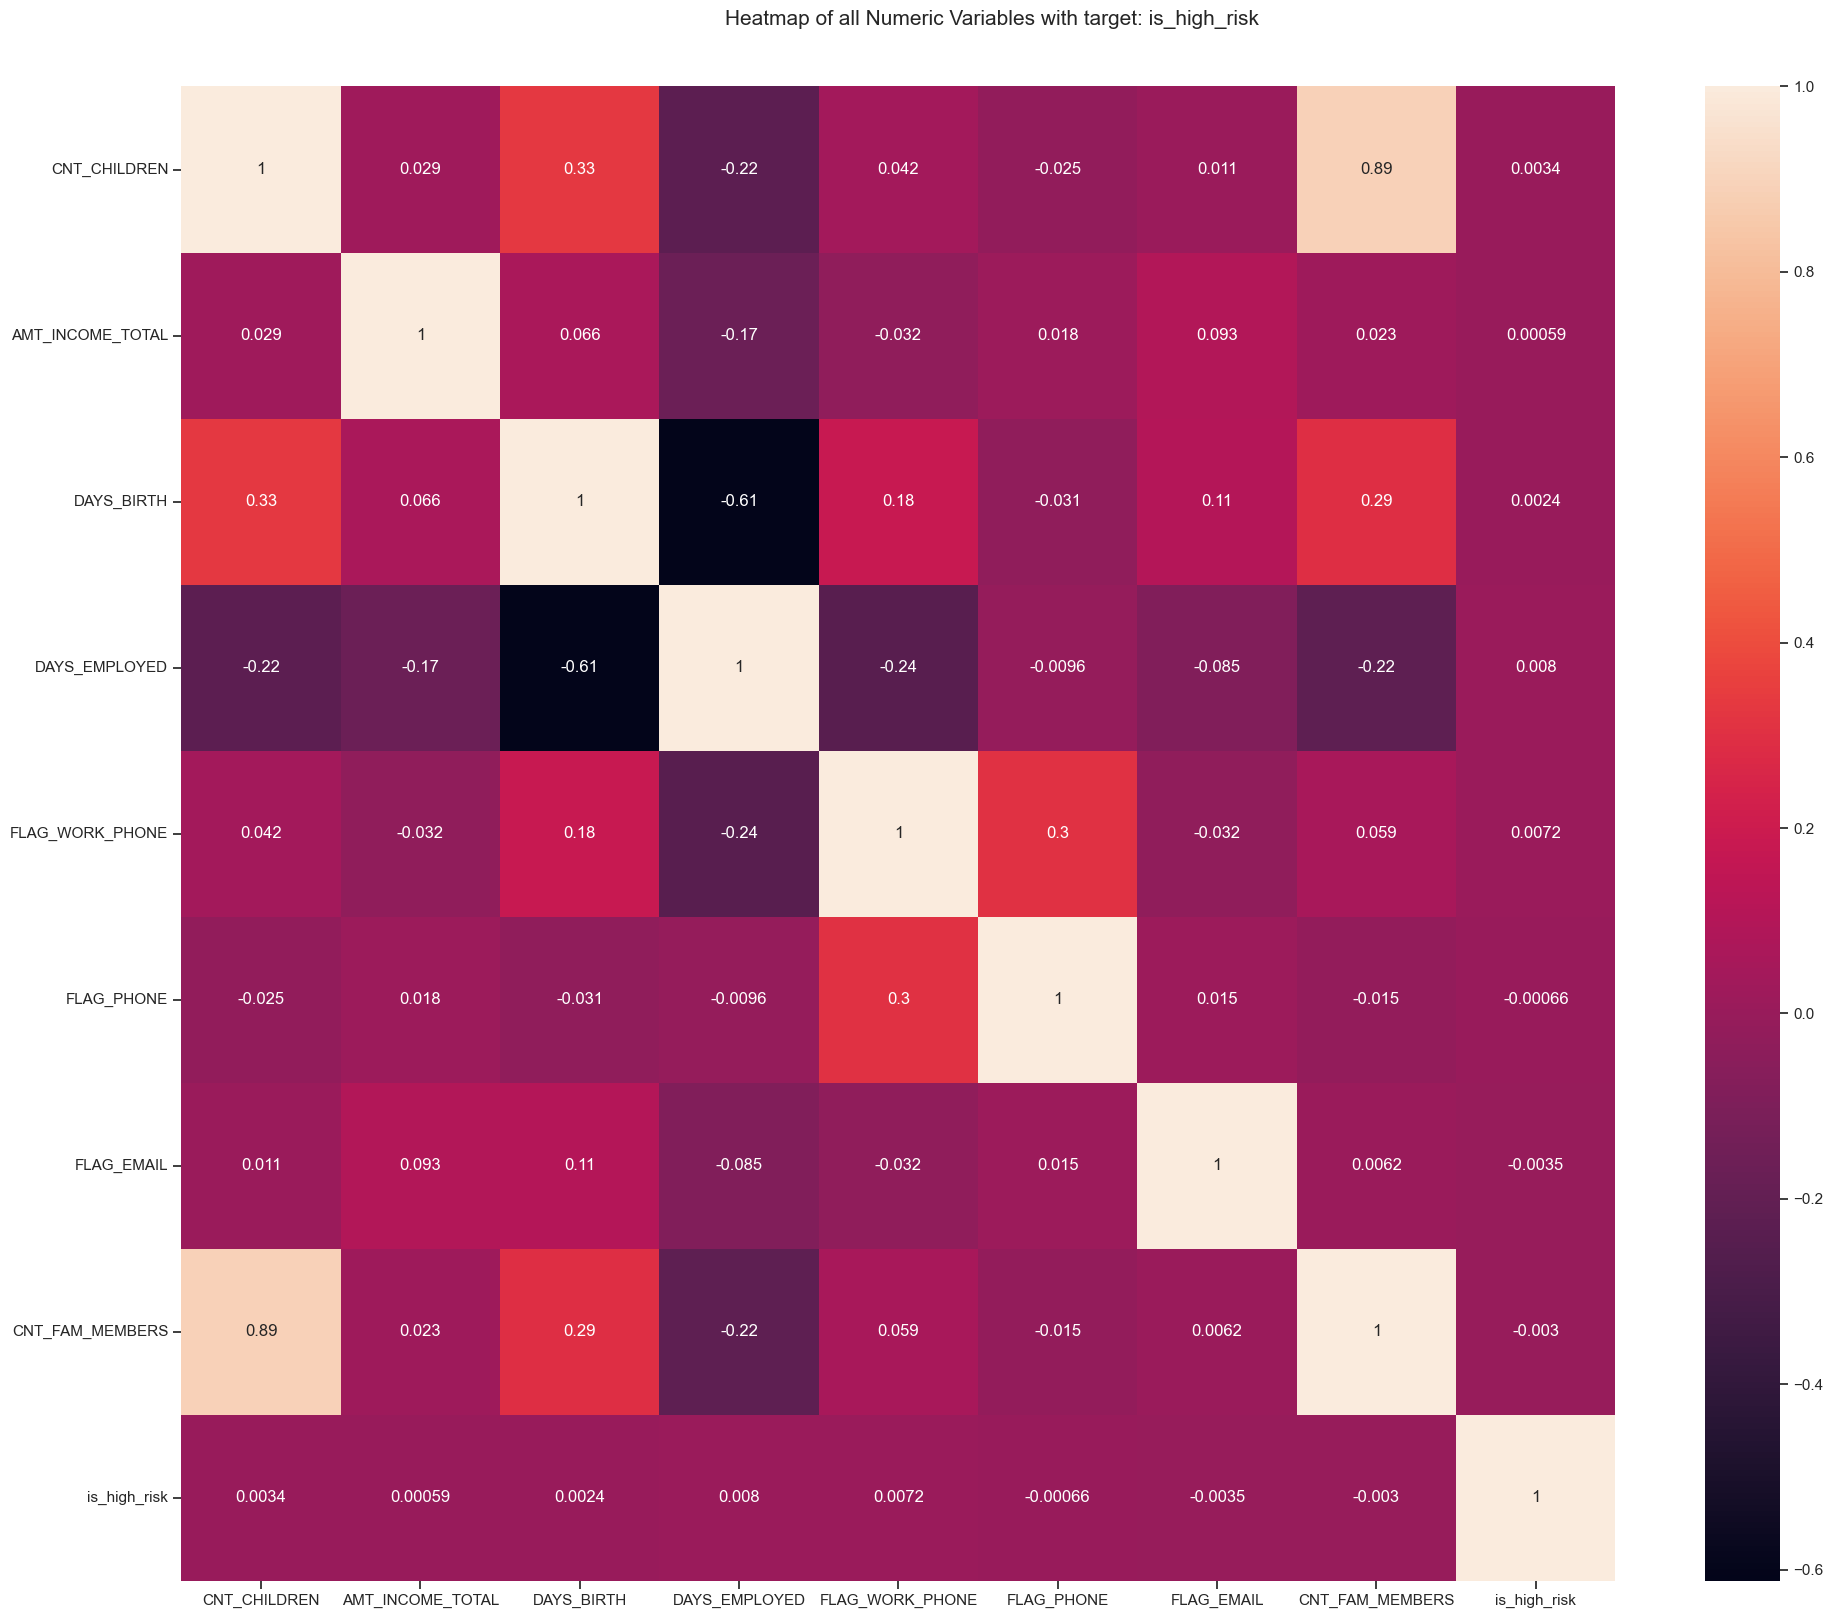

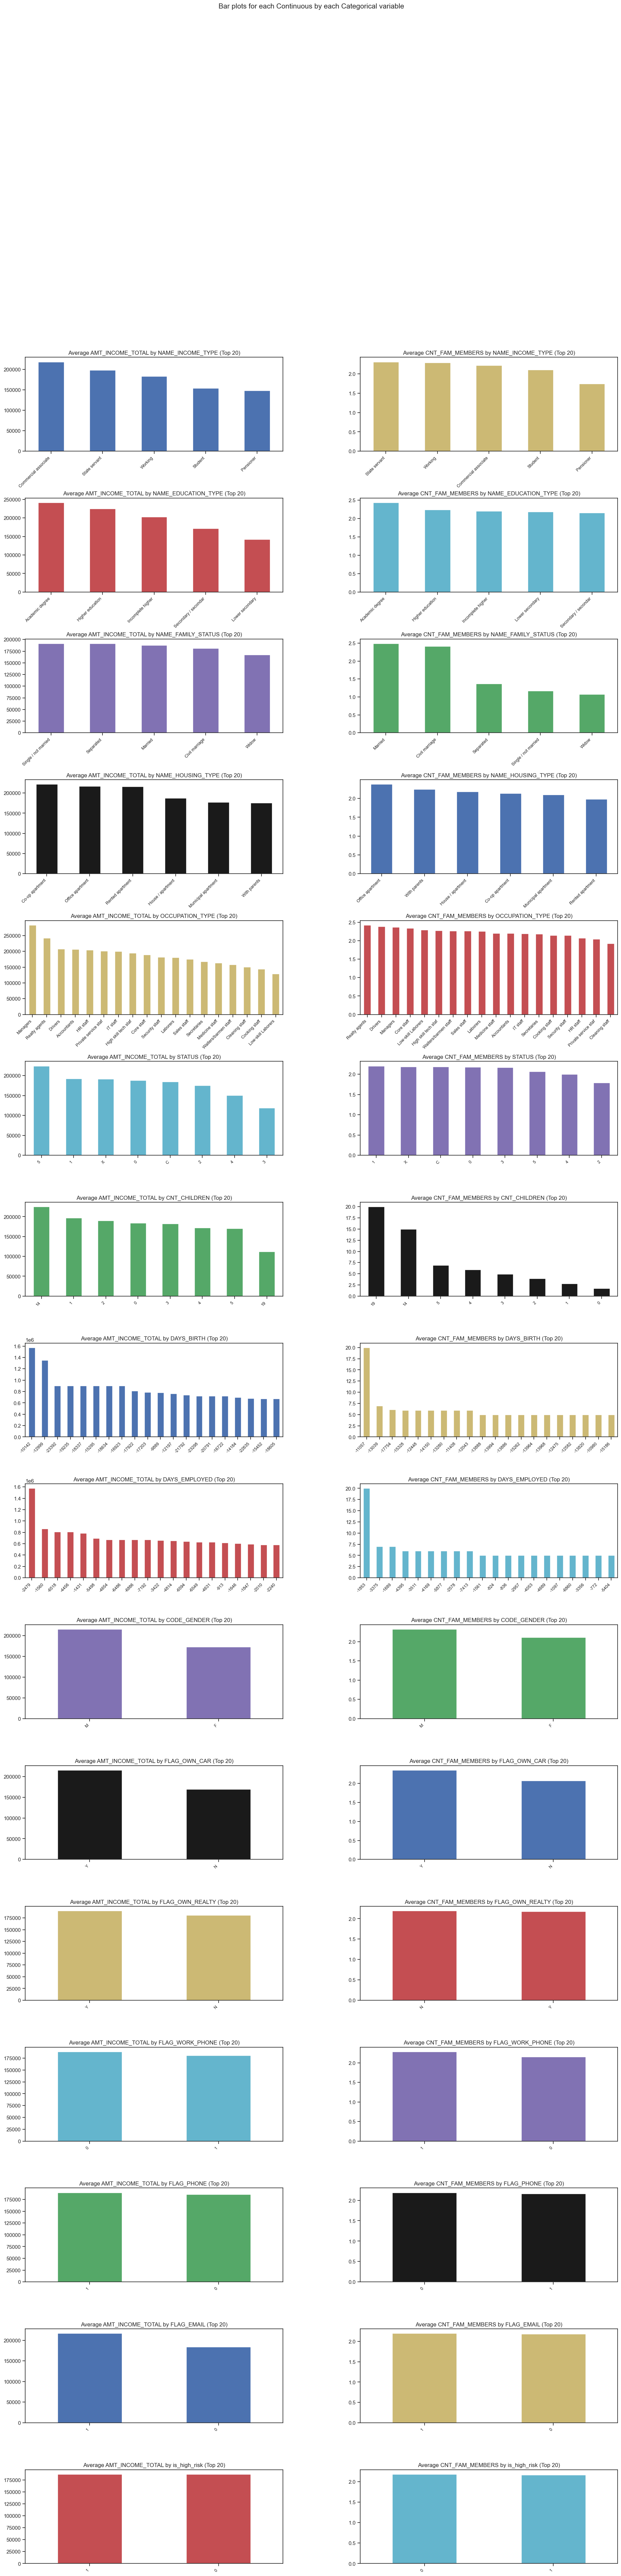

In [25]:
# Autoviz display
%matplotlib inline
AV = AutoViz_Class()
dfte = AV.AutoViz(filename="", sep=',', depVar='is_high_risk', dfte=merged_df, header=0, verbose=2, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir="reports_html")

In [45]:
#autoviz report to html
#generate_autoviz_html_report(folder_name="reports_html/is_high_risk", output_filename="credit_card_eda_report.html")

✅ AutoViz HTML report saved to: D:\portfolio\my_projects\DataAnalysis\notebooks\reports_html\Is_high_risk\credit_card_eda_report.html


'D:\\portfolio\\my_projects\\DataAnalysis\\notebooks\\reports_html\\Is_high_risk\\credit_card_eda_report.html'

### Initial EDA & DQ Issues Summary Report

*Project Goal (Recap)*

> Build a predictive model to identify **high-risk** customers for credit card approval

- *EDA Findings

| **Section**               | **Key Findings** |
|---------------------------|--------------|
|Distribution of Numerical Features | - Skewed features like income and credit history suggest outliers.<br>- Some features closer to normal distribution.<br>- Transformations (log, Box-Cox) recommeT |
|Target Variable        | - Imbalanced target: fewer high-risk customers.<br>- Consider SMOTE or `class_we`. |
|Correlation Heatmap   | - Strong correlations (e.g., income vs. credit score).<br>- Risk of multicollinearity – apply PCA or drne. |
|Pairwise Relationships| - Visual clusters and outliers.<br>- Useful for feature selection and nonlinearels. |
|Box Plots             | - Clear separation in features like income, credit score between risk groups.<br>- Use as predictivenals. |
|Categorical Features  | - Some variables imbalanced or have rare categories.<br>- Encoding and groupieeded. |
|Data Quality          | - Outliers, skewed distributions, missing values.<br>- Mixed data types and imbalanced target * |

- *Data Quality Table*

| **Column**            | **DQ Issues** |
|-------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| `CNT_CHILDREN`          | - Outliers: 205 values outside [-1.5, 2.5].<br>- High correlation with `CNT_FAM_MEMBERS`. Drop one. |
| `AMT_INCOME_TOTAL`      | - Outliers: 496 values outside [-45,000, 387,000]. Cap or remove. |
| `NAME_INCOME_TYPE`      | - Rare category: `Student`. Consider grouping or dropping. |
| `NAME_EDUCATION_TYPE`   | - Rare category: `Academic degree`. Consider grouping or dropping. |
| `NAME_HOUSING_TYPE`     | - Rare categories: `Office apartment`, `Co-op apartment`. Group or drop. |
| `DAYS_EMPLOYED`         | - Outliers: 3,011 values outside [-7,086, 3,666]. Cap or remove. |
| `OCCUPATION_TYPE`       | - 30.73% missing.<br>- 6 rare categories.<br>- Mixed data types. Impute/group/convert. |
| `CNT_FAM_MEMBERS`       | - Outliers: 195 values outside [0.5, 4.5]. Cap or remove. |
| `STATUS`                | - Rare categories: `2`, `3`, `4`, `5`. Group or drop. |
| `Is_high_risk`      | I'll be using SMOTE algorithms. |


- *Initial Recommendations*

| **Step**              | **Recommendation** |
|-----------------------|--------------------|
| Preprocessing         | - Scale features (StandardScaler/MinMaxScaler)<br>- Transform skewed variables (log/Box-Cox)<br>- Address class imbalance |
| Feature Engineering   | - Bin credit metrics<br>- Create interaction terms |
| Modeling              | - Use tree-based models (Random Forest, XGBoost)<br>- Try logistic regression as baseline<br>- Optimize using AUC/recall/precision |

## Data Preprocessing
- Handle Rare categories, Outliers(capping), missing values in `OCCUPATION_TYPE`== drop 
- Scale features (StandardScaler/MinMaxScaler)
- Transform skewed variables (log/Box-Cox)
- Address class imbalance

In [69]:
cleaned_df = merged_df.copy()

In [70]:
# Standardize text columns
for col in cleaned_df.select_dtypes(include='object').columns:
    cleaned_df[col] = cleaned_df[col].str.strip().str.lower()  # convert to lowercase for consistency

In [71]:
# check datatypes
detect_columns(cleaned_df)

,Category,Columns,Count
0,Dates,[],0
1,Numerical,"[ID, CNT_CHILDREN, AMT_INCOME_TOTAL, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, MONTHS_BALANCE, is_high_risk]",12
2,Binary,"[CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY]",3
3,Multi-Category,"[NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, STATUS]",5
4,Irrelevant,[OCCUPATION_TYPE],1


In [72]:
# Drop redundant/ID Column
cleaned_df.drop(['OCCUPATION_TYPE', 'ID'], axis="columns", inplace=True) # dropping the column `OCCUPATION_TYPE`

#### Check unique values to address column inconsistencies

In [73]:
for col in cleaned_df.select_dtypes(include='object').columns:
    print(f"{col}: {cleaned_df[col].unique()}")

CODE_GENDER: ['m' 'f']
FLAG_OWN_CAR: ['y' 'n']
FLAG_OWN_REALTY: ['y' 'n']
NAME_INCOME_TYPE: ['working' 'commercial associate' 'pensioner' 'state servant' 'student']
NAME_EDUCATION_TYPE: ['higher education' 'secondary / secondary special' 'incomplete higher'
 'lower secondary' 'academic degree']
NAME_FAMILY_STATUS: ['civil marriage' 'married' 'single / not married' 'separated' 'widow']
NAME_HOUSING_TYPE: ['rented apartment' 'house / apartment' 'municipal apartment'
 'with parents' 'co-op apartment' 'office apartment']
STATUS: ['c' '0' 'x' '1' '5' '3' '4' '2']


In [76]:
# Clean and map education type
education_map = {
    'lower secondary': 'Lower secondary',
    'incomplete higher': 'Incomplete higher',
    'secondary / secondary special': 'Secondary',
    'higher education': 'Higher',
    'academic degree': 'Academic'
}
cleaned_df['NAME_EDUCATION_TYPE'] = cleaned_df['NAME_EDUCATION_TYPE'].map(education_map)

In [77]:
# Group rare income types
income_counts = cleaned_df['NAME_INCOME_TYPE'].value_counts(normalize=True)
rare_income_types = income_counts[income_counts < 0.01].index
cleaned_df['NAME_INCOME_TYPE'] = cleaned_df['NAME_INCOME_TYPE'].replace(rare_income_types, 'other')


In [78]:
# Group rare housing types
rare_housing = ['co-op apartment', 'office apartment']
cleaned_df['NAME_HOUSING_TYPE'] = cleaned_df['NAME_HOUSING_TYPE'].replace(rare_housing, 'other')

# Optional: map to cleaner labels
housing_map = {
    'rented apartment': 'rented',
    'house / apartment': 'owned',
    'municipal apartment': 'municipal',
    'with parents': 'with_parents',
    'other': 'other'
}
cleaned_df['NAME_HOUSING_TYPE'] = cleaned_df['NAME_HOUSING_TYPE'].map(housing_map)

In [79]:
# maping the values in status column and storing result in new column

cleaned_df['loan_status'] = cleaned_df['STATUS'].map({'0': 'first_month_due' , '1': '2nd_month_due', '2' : '3rd_month_overdue',  '3': '4th_month_overdue',
                                '4' : '5th_month_overdue', 's' : 'bad_debt' , 'c': 'good' , 'x' : 'no_loan'})

In [80]:
# unique values after cleaning
for col in cleaned_df.select_dtypes(include='object').columns:
    print(f"{col}: {cleaned_df[col].unique()}")

CODE_GENDER: ['m' 'f']
FLAG_OWN_CAR: ['y' 'n']
FLAG_OWN_REALTY: ['y' 'n']
NAME_INCOME_TYPE: ['working' 'commercial associate' 'pensioner' 'state servant' 'other']
NAME_EDUCATION_TYPE: [nan]
NAME_FAMILY_STATUS: ['civil marriage' 'married' 'single / not married' 'separated' 'widow']
NAME_HOUSING_TYPE: ['rented' 'owned' 'municipal' 'with_parents' 'other']
STATUS: ['c' '0' 'x' '1' '5' '3' '4' '2']
loan_status: ['good' 'first_month_due' 'no_loan' '2nd_month_due' nan
 '4th_month_overdue' '5th_month_overdue' '3rd_month_overdue']


#### renaming columns in a meaning full way

In [81]:
cleaned_df.rename(columns={
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_property',
    'CNT_CHILDREN': 'children',
    'AMT_INCOME_TOTAL': 'income',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'FLAG_MOBIL': 'mobile',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email',
    'CNT_FAM_MEMBERS': 'family_members',
    'MONTHS_BALANCE': 'months_balance',
    'STATUS' : 'status',
    'DAYS_BIRTH' : 'age_in_days',
    'DAYS_EMPLOYED' : 'employment_in_days'

} , inplace=True)

In [82]:
cleaned_df.head()

,gender,own_car,own_property,children,income,income_type,education,family_status,housing_type,age_in_days,employment_in_days,mobile,work_phone,phone,email,family_members,months_balance,status,is_high_risk,loan_status
0,m,y,y,0,427500.0,working,NaN,civil marriage,rented,-12005,-4542,1,1,0,0,2.0,0,c,0,good
1,m,y,y,0,427500.0,working,NaN,civil marriage,rented,-12005,-4542,1,1,0,0,2.0,0,c,0,good
2,m,y,y,0,112500.0,working,NaN,married,owned,-21474,-1134,1,0,0,0,2.0,0,c,0,good
3,f,n,y,0,270000.0,commercial associate,NaN,single / not married,owned,-19110,-3051,1,0,1,1,1.0,0,0,0,first_month_due
4,f,n,y,0,270000.0,commercial associate,NaN,single / not married,owned,-19110,-3051,1,0,1,1,1.0,0,c,0,good


#### Handling outliers (cap)

In [84]:
#cap all outliers
cleaned_df = cap_outliers_all(cleaned_df)

In [85]:
# Check for outliers across all numeric columns using IQR
outlier_counts = detect_outliers_all(cleaned_df)
print(outlier_counts)

                    outlier_count
children                  0      
income                    0      
age_in_days               0      
employment_in_days        0      
family_members            0      


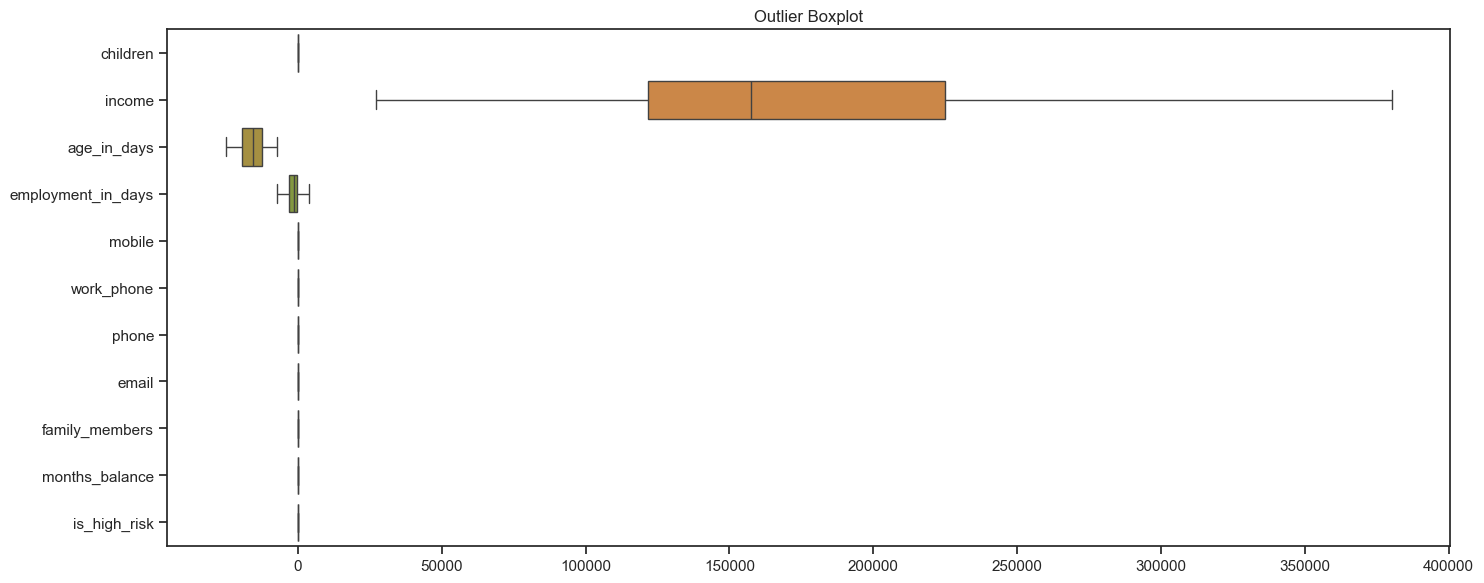

In [86]:
# plot capped df
plot_outliers_boxplot(cleaned_df, title="Outlier Boxplot", figsize=(15, 6))

## Correlations & Hypothesis Testing (CHI-SQUARE & ANOVA)
- This section uses Chi-Square Test to test if a categorical column has a relation with is_high_risk label while also presenting visualizations to explore how each feature is distributed across risky and non-risky customers.

## Feature Engineering
- Bin credit metrics
- Create interaction terms

## Modeling
- Use tree-based models (Random Forest, XGBoost)
- Try logistic regression as baseline
- Optimize using AUC/recall/precision

In [1]:
# streamlit

In [ ]:
import streamlit as st
import eda
import prediction

page = st.sidebar.selectbox('Pilih Halaman', ('EDA', 'Prediction'))

if page=='EDA':
    eda.run()
else:
    prediction.run()

In [ ]:
import streamlit as st
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

def run():

    #Membuat judul
    st.title('Credit Card Analysis and Prediction')

    image = Image.open('credit_card.jpeg')
    st.image(image, caption='Credit Card')

    st.markdown('------')

    #Sub judul untuk Exploratory Data Analysis
    st.subheader('Exploratory Data Analysis Credit Card')

    #Memanggil dataset
    credit_card_data = pd.read_csv('P1G5_Set_1_Christopher.csv')
    credit_card_data

    st.write("#### Penggunaan Credit Card berdasarkan Age")
    fig = plt.figure(figsize=(20, 15))
    sns.countplot(credit_card_data, x="age")
    st.pyplot(fig)

    st.write("#### Limit Balance menurut Education Level")
    limit_by_education = credit_card_data.groupby('education_level')['limit_balance'].sum().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.bar(limit_by_education.education_level, limit_by_education.limit_balance, label=limit_by_education.limit_balance)

    ax.set_ylabel('Education Level')
    ax.set_title('Limit Balance')
    ax.legend(title='Limit Balance menurut Education Level')
    st.pyplot(fig, ax)

    st.write("#### Limit Balance menurut Age")
    limit_by_age = credit_card_data.groupby('age')['limit_balance'].sum().sort_values(ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(20, 10))

    ax.bar(limit_by_age.age, limit_by_age.limit_balance)

    ax.set_ylabel('Education Level')
    ax.set_title('Limit Balance')
    ax.legend(title='Limit Balance menurut Education Level')
    st.pyplot(fig, ax)

if __name__ == "__main__":
    run()

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import json
import pickle
from sklearn import *

with open('best_models_knc.pkl', 'rb') as file_3:
  knc_model = pickle.load(file_3)

with open('best_models_svc.pkl', 'rb') as file_6:
  svc_model = pickle.load(file_6)

with open('best_models_logreg.pkl', 'rb') as file_7:
  logreg_model = pickle.load(file_7)

def run():
    st.title('Prediction Credit Card Default or Not')

    with st.form('form_credit_card'):
       limit_balance = st.slider('Limit Balance', min_value = 0, max_value = 500000, value = 150000, help='Slide limit balance anda')
       pay_amt_1 = st.slider('Input Payment 1', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment pertama anda')
       pay_amt_2 = st.slider('Input Payment 2', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment kedua anda')
       pay_amt_3 = st.slider('Input Payment 3', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment ketiga anda')
       pay_amt_4 = st.slider('Input Payment 4', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment keempat anda')
       pay_amt_5 = st.slider('Input Payment 5', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment kelima anda')
       pay_amt_6 = st.slider('Input Payment 6', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah payment keenam anda')
       education_level = st.slider('Education Level', min_value = 0, max_value = 6, value = 3, help='Slide education level anda')
       pay_0 = st.slider('Input Payment 1', min_value = -2, max_value = 9, value = 3, help='Slide status payment pertama anda')
       pay_2 = st.slider('Input Payment 2', min_value = -2, max_value = 9, value = 3, help='Slide status payment kedua anda')
       pay_3 = st.slider('Input Payment 3', min_value = -2, max_value = 9, value = 3, help='Slide status payment ketiga anda')
       pay_4 = st.slider('Input Payment 4', min_value = -2, max_value = 9, value = 3, help='Slide status payment keempat anda')
       pay_5 = st.slider('Input Payment 5', min_value = -2, max_value = 9, value = 3, help='Slide status payment kelima anda')
       pay_6 = st.slider('Input Payment 6', min_value = -2, max_value = 9, value = 3, help='Slide status payment keenam anda')
       bill_amt_1 = st.slider('Input Jumlah Tagihan 1', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan pertama anda')
       bill_amt_2 = st.slider('Input Jumlah Tagihan 2', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan kedua anda')
       bill_amt_3 = st.slider('Input Jumlah Tagihan 3', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan ketiga anda')
       bill_amt_4 = st.slider('Input Jumlah Tagihan 4', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan keempat anda')
       bill_amt_5 = st.slider('Input Jumlah Tagihan 5', min_value = 0, max_value = 500000, value = 150000, help='Slide jumlah tagihan kelima anda')
       bill_amt_6 = st.slider('Input Jumlah Tagihan 6', min_value = 0, max_value = 300000, value = 150000, help='Slide jumlah tagihan keenam anda')

       #submit button
       submitted = st.form_submit_button('Predict')

    data_inf = {
    "limit_balance"  :               limit_balance,
    "pay_amt_1"      :                pay_amt_1,
    "pay_amt_2"      :                pay_amt_2,
    "pay_amt_3"      :                pay_amt_3,
    "pay_amt_4"      :                pay_amt_4,
    "pay_amt_5"      :                pay_amt_5,
    "pay_amt_6"      :                pay_amt_6,
    "education_level":          education_level,
    "pay_0"          :                   pay_0,
    "pay_2"          :                   pay_2,
    "pay_3"          :                   pay_3,
    "pay_4"          :                   pay_4,
    "pay_5"          :                   pay_5,
    "pay_6"          :                   pay_6,
    "bill_amt_1"     :               bill_amt_1,
    "bill_amt_2"     :               bill_amt_2,
    "bill_amt_3"     :               bill_amt_3,
    "bill_amt_4"     :               bill_amt_4,
    "bill_amt_5"     :               bill_amt_5,
    "bill_amt_6"     :               bill_amt_6
    }       

    data_inf = pd.DataFrame([data_inf])
    data_inf

    if submitted:

        y_pred_inf = logreg_model.predict(data_inf)
        y_pred_inf

        st.write('### Default Payment Next Month: ', str(int(y_pred_inf)))


if __name__ == "__main__":
    run()